In [19]:
# figuring out the best player over all minigames 

'''
    Each Minigame may yield a total of 100 points per player. 
    Records #1 through #10 are considered 

    If a minigame has multiple maps, the 100 points are distributed equally. For Sammelwahn and Replika, the sum over all records is considered solely. 

    E.g. Frozen Path (1 Map Minigame)
    #1 player: 100 points
    #2 player: 90 points
    #3 player: 80 points
    ...
    #10 player: 10 points

    E.g. Schießstand (3 Map Minigame)
    Map 1: 
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 2:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 3:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...

    E.g. Speed Race (5 Map Minigame)
    Map 1:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...
    Map 2:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...

    Thus, a player holding #1 records in a minigame will always be assigned 100 points. 
'''

'\n    Each Minigame may yield a total of 100 points per player. \n    Records #1 through #10 are considered \n\n    If a minigame has multiple maps, the 100 points are distributed equally. For Sammelwahn and Replika, the sum over all records is considered solely. \n\n    E.g. Frozen Path (1 Map Minigame)\n    #1 player: 100 points\n    #2 player: 90 points\n    #3 player: 80 points\n    ...\n    #10 player: 10 points\n\n    E.g. Schießstand (3 Map Minigame)\n    Map 1: \n    #1 player: 100/3 (33.333) points\n    #2 player: 90/3 (30) points\n    ...\n    Map 2:\n    #1 player: 100/3 (33.333) points\n    #2 player: 90/3 (30) points\n    ...\n    Map 3:\n    #1 player: 100/3 (33.333) points\n    #2 player: 90/3 (30) points\n    ...\n\n    E.g. Speed Race (5 Map Minigame)\n    Map 1:\n    #1 player: 100/5 (20) points\n    #2 player: 90/5 (18) points\n    ...\n    Map 2:\n    #1 player: 100/5 (20) points\n    #2 player: 90/5 (18) points\n    ...\n\n    Thus, a player holding #1 records in 

In [20]:
import os
import re 
import pandas as pd
import seaborn as sns 
import numpy as np 

pointMiniGames = "Sammelwahn, Schießstand, Walls, Mini Survivalgames, Mini Skywars, Lasertag, Minengefecht, Einer im Köcher, Paintball, Spleef, Buntes Chaos, Duelle" 
timeMiniGames = "Wettrennen, Jump and Run, Pferderennen, Drachenflucht, Replika, Blockhüpfer, Todeswürfel, Freier Fall, Elytrarennen, Waffenfolge, Minenfeld, Kletter-König, Ampelrennen, Hoch hinaus, Frostiger Pfad"

def getPlayerPaths():
    file_list = os.listdir('in-new')
    return file_list

def read_file(file):
    try:
        with open('in-new/' + file, 'r', encoding='utf-8') as f:
            data = f.read()
    except UnicodeDecodeError:
        # print(f'Error: {file} contains invalid characters for UTF-8. Trying with latin-1.')
        try:
            with open('in-new/' + file, 'r', encoding='latin-1') as f:
                data = f.read()
        except Exception as e:
            print(f'Error: Could not read {file} with latin-1 encoding. {e}')
            return None
    except FileNotFoundError:
        print(f'Error: {file} not found.')
        return None
    except Exception as e:
        print(f'Error: An unexpected error occurred while reading {file}. {e}')
        return None

    if "TooltipEvent" not in data:
        print(f'Error: {file} does not contain any TooltipEvent data')
        return None
    else:
        data = data.replace('TooltipEvent, ', '')
    
    return data


def getRecordData(playerPath, minigame):
    # if read_file(playerPath) is None: return None

    data = read_file(playerPath).split('\n')
    for line in data: 
        if minigame in line: 
            minigameData = line
            minigameData = minigameData.replace(minigame, '').strip()
            return minigameData  # return the data instead of printing it

def create_dataframe(input_string, minigame):

    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(?:(\d+)\s*min\s*)?(?:(\d+)\s*s\s*)?(\d+)\s*ms'

    # Find all matches in the input string
    try: matches = re.findall(pattern, input_string)
    except: matches = None

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    if matches: 
        for match in matches:
            map_name = match[0]
            minutes = int(match[1] or 0)
            seconds = int(match[2] or 0) + int(match[3]) / 1000
            time_seconds = minutes * 60 + seconds
            data[map_name] = time_seconds
    else: return pd.DataFrame()

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])


    return df

def createPointDataframe(input_string, minigame):
    # Define regular expression pattern to match map names and times
    pattern = r'(\w+\s?\w+)\s*:\s*(\d+)'

    # Find all matches in the input string
    matches = re.findall(pattern, input_string)

    # Initialize data dictionary to store map names and times
    data = {}

    # Iterate over matches and populate data dictionary
    for match in matches:
        map_name = match[0]
        time_value = int(match[1])
        data[map_name] = time_value

    # Create DataFrame from data dictionary
    df = pd.DataFrame(data, index=[0])
    return df.fillna(0)

def getRecordsDataframe(minigame='Wettrennen', save=False, log=False, html=False, rank=True):

    paths = getPlayerPaths()

    outDf = pd.DataFrame()

    if log:
        print(f'processing {minigame}...')

    if minigame in pointMiniGames: 
        pass
    elif minigame in timeMiniGames:
        pass
    else: 
        ValueError('Not a valid minigame name')

    for i in paths:
        if minigame in timeMiniGames:
            df = create_dataframe(getRecordData(playerPath=i, minigame=minigame), minigame)

        if minigame in pointMiniGames:
            try: 
                df = createPointDataframe(getRecordData(playerPath=i, minigame=minigame), minigame)
                df.fillna(0, inplace=True)
            except: 
                continue

        if df is not None:  
            df.index = [i.replace('.txt', '')]
            outDf = pd.concat([outDf, df])

    outPath = 'out/' + minigame + '.json'

    '''
        Minigame Specific changes to the df
    '''

    if ("Replika" in minigame): 

        replikaDf = outDf 

        # fillNa columns without "ms" with values from "ms", e.g. ms Arrow -> Arrow, then drop "ms" columns

        try:
            replikaDf["Arrow"] = replikaDf["Arrow"].fillna(replikaDf["ms Arrow"])
            replikaDf["Cow"] = replikaDf["Cow"].fillna(replikaDf["ms Cow"])
            replikaDf["Deadpool"] = replikaDf["Deadpool"].fillna(replikaDf["ms Deadpool"])
            replikaDf["Doge"] = replikaDf["Doge"].fillna(replikaDf["ms Doge"])
            replikaDf["Sonic"] = replikaDf["Sonic"].fillna(replikaDf["ms Sonic"])

            replikaDf.drop(columns=["ms Arrow", "ms Cow", "ms Deadpool", "ms Doge", "ms Sonic"], inplace=True)
        except: print("Warning, >ms< columns not found in ReplikaDf")

        replikaDf.fillna(25, inplace=True) # assigning a value to a never-played-before pattern, 17 perturbs worse player order and alt account stats lol, 27 is probably too much, difficult to choose an appropriate value here
        row_sums = replikaDf.sum(axis=1)
        
        # Append the sum as a new column
        replikaDf['Sum'] = row_sums

        # Re-indexing
        replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)
    
        # Move 'Sum' column to the first position
        cols = replikaDf.columns.tolist()
        cols = ['Sum'] + [col for col in cols if col != 'Sum']
        replikaDf = replikaDf[cols]

        # replace 25 values again with None
        replikaDf = replikaDf.replace(25, np.nan)

        # replikaDf = replikaDf.reindex(sorted(replikaDf.columns), axis=1)


        # Removing player data with too many NaNs (players that haven't played most of the patterns)
        # replikaDf = replikaDf.drop(columns=["Ritokii", "Feinberg", "Sebi1801"])

        outDf = replikaDf

    if ("Sammelwahn" in minigame):

            row_sums = outDf.sum(axis=1)

            # Append the sum as a new column
            outDf['Sum'] = row_sums

            # Re-indexing
            outDf = outDf.reindex(sorted(outDf.columns), axis=1)

            # Move 'Sum' column to the first position
            cols = outDf.columns.tolist()
            cols = ['Sum'] + [col.lstrip() for col in cols if col != 'Sum']
            outDf = outDf[cols]

            # remove "Punkte" from all columns
            outDf.columns = outDf.columns.str.replace('Punkte', '')

    if ("Lasertag" in minigame):
        # Merge the columns "tungen Port" and "Port" into one column
        
        # debug 
        # print(outDf.columns)

        try:

            outDf["Tötungen Port"] = outDf["Tötungen Port"].replace(0, np.nan)

            outDf["temp1"] = outDf["Tötungen Port"]
            try: outDf.drop(columns=["Port"], inplace=True)
            except: pass
            outDf["Port"] = outDf["temp1"]

            outDf["Tötungen Neon"] = outDf["Tötungen Neon"].replace(0, np.nan)

            outDf["temp2"] = outDf["Tötungen Neon"]
            try: outDf.drop(columns=["Neon"], inplace=True)
            except: pass
            outDf["Neon"] = outDf["temp2"]

            outDf.drop(columns=["temp1", "temp2", "Tötungen Neon", "Tötungen Port"], inplace=True)  

        except: pass

    if ("Einer im Köcher" in minigame):
        try:
            outDf["Tötungen Asia"] = outDf["Tötungen Asia"].replace(0, np.nan)
            outDf["Asia"] = outDf["Asia"].replace(0, np.nan)

            outDf["temp1"] = outDf["Asia"].fillna(outDf["Tötungen Asia"])
            outDf.drop(columns=["Asia", "Tötungen Asia"], inplace=True)
        except: pass
            
        try:
            outDf["Asia"] = outDf["temp1"]

            outDf["Tötungen Japan"] = outDf["Tötungen Japan"].replace(0, np.nan)
            outDf["Japan"] = outDf["Tötungen Japan"]

            outDf.drop(columns=["temp1", "Tötungen Japan"], inplace=True)
        except: pass
        
    if ("Paintball" in minigame):
        outDf["Tötungen Arabic"] = outDf["Tötungen Arabic"].replace(0, np.nan)

        outDf["temp1"] = outDf["Tötungen Arabic"]
        try: outDf.drop(columns=["Tötungen Arabic"], inplace=True)
        except: pass
        outDf["Arabic"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)

        # SW Columns: Swamp', 'Tötung Asia', 'Tötungen Asia', 'Tötungen Coconut', 'Wild West', 'tung Asia', 'tungen Asia'

    if ("Mini Skywars" in minigame):

        print(outDf.columns)

        outDf["Tötungen Asia"] = outDf["Tötungen Asia"].replace(0, np.nan)
        outDf["Tötung Asia"] = outDf["Tötung Asia"].replace(0, np.nan)
        outDf["Asia"] = outDf["Asia"].replace(0, np.nan)
        #outDf["tung Asia"] = outDf["tung Asia"].replace(0, np.nan)
        
        outDf["temp1"] = outDf["Tötung Asia"]

        outDf["temp1"] = outDf["Tötungen Asia"].fillna(outDf["Tötung Asia"])
        outDf["temp1"] = outDf["temp1"].fillna(outDf["Asia"])
        #outDf["temp1"] = outDf["Tötungen Asia"].fillna(outDf["tung Asia"])
        try: outDf.drop(columns=["Tötung Asia", "Tötungen Asia", "Asia"], inplace=True)
        except: pass
        outDf["Asia"] = outDf["temp1"]

        outDf["Tötungen Coconut"] = outDf["Tötungen Coconut"].replace(0, np.nan)
        #outDf["tungen Coconut"] = outDf["tungen Coconut"].replace(0, np.nan)

        #outDf["temp2"] = outDf["tungen Coconut"].fillna(outDf["Tötungen Coconut"])
        try: outDf.drop(columns=["tungen Coconut", "Tötungen Coconut"], inplace=True)
        except: pass
        #outDf["Coconut"] = outDf["temp2"]

        outDf["Rust"] = outDf["Tötungen Rust"]
        outDf.drop(columns=["Tötungen Rust"], inplace=True)

        outDf.drop(columns=["temp1"], inplace=True)

        outDf["Tötungen Coconut"] = outDf["Tötungen Coconut"].replace(0, np.nan).fillna(outDf["Tötung Coconut"])

        outDf["temp1"] = outDf["Tötungen Coconut"]
        try: outDf.drop(columns=["Tötungen Coconut"], inplace=True)
        except: pass
        outDf["Coconut"] = outDf["temp1"]

        outDf.drop(columns=["temp1", "Tötung Coconut"], inplace=True)

        outDf["Tötung Rust"] = outDf["Tötung Rust"].replace(0, np.nan)
        outDf["Rust"] = outDf["Rust"].fillna(outDf["Tötung Rust"])

        try: 
            outDf.drop(columns=["Tötung Rust"], inplace=True)
        except: pass

    if ("Mini Survivalgames" in minigame and True):
        #outDf["Tötungen Prison"] = outDf["Tótungen Prison"].replace(0, np.nan)
        outDf["Tötung Prison"] = outDf["Tötung Prison"].replace(0, np.nan)
        outDf["Prison"] = outDf["Prison"].replace(0, np.nan)
        # outDf["Prison"] = outDf["Prison"].fillna(outDf["Tötungen Prison"])
        outDf["Prison"] = outDf["Prison"].fillna(outDf["Tötung Prison"])

        try:
            outDf.drop(columns=["Tötungen Prison", "Tötung Prison"], inplace=True)
        except: pass

    if ("Minengefecht" in minigame):
        outDf["Tötungen Overworld"] = outDf["Tötungen Overworld"].replace(0, np.nan)
        outDf["Overworld"] = outDf["Overworld"].replace(0, np.nan)

        outDf["temp1"] = outDf["Overworld"].fillna(outDf["Tötungen Overworld"])
        outDf["temp1"] = outDf["temp1"]

        try: outDf.drop(columns=["Overworld", "Tötungen Overworld"], inplace=True)
        except: pass
        outDf["Overworld"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)
        
        outDf["Tötungen Ruin"] = outDf["Tötungen Ruin"].replace(0, np.nan)

        outDf["temp2"] = outDf["Tötungen Ruin"]
        try: outDf.drop(columns=["Tötungen Ruin"], inplace=True)
        except: pass
        outDf["Ruin"] = outDf["temp2"]

        outDf.drop(columns=["temp2"], inplace=True)

        try: outDf.drop(columns=["Tötung Overworld", "Tötung Ruin"], inplace=True)
        except: pass

    if ("Walls" in minigame):
        
        outDf["Tötungen Grass"] = outDf["Tötungen Grass"].replace(0, np.nan)
        outDf["Grass"] = outDf["Grass"].replace(0, np.nan)
        outDf["Tötung Grass"] = outDf["Tötung Grass"].replace(0, np.nan)

        outDf["temp1"] = outDf["Grass"].fillna(outDf["Tötungen Grass"])
        outDf["temp1"] = outDf["temp1"].fillna(outDf["Tötung Grass"])

        try: outDf.drop(columns=["Grass", "Tötungen Grass", "Tötung Grass"], inplace=True)
        except: pass

        outDf["Grass"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)
        
        outDf["Tötungen Vulcano"] = outDf["Tötungen Vulcano"].replace(0, np.nan)

        outDf["temp2"] = outDf["Tötungen Vulcano"]
        try: outDf.drop(columns=["Tötungen Vulcano"], inplace=True)
        except: pass
        outDf["Vulcano"] = outDf["temp2"]

        outDf.drop(columns=["temp2"], inplace=True)

        try: outDf.drop(columns=["Tötung Vulcano"], inplace=True)
        except: pass

    if ("Schie" in minigame):
        outDf["Punkte City"] = outDf["Punkte City"].replace(0, np.nan)
        outDf["City"] = outDf["City"].replace(0, np.nan)

        outDf["temp1"] = outDf["City"].fillna(outDf["Punkte City"])
        try: outDf.drop(columns=["City", "Punkte City"], inplace=True)
        except: pass

        outDf["City"] = outDf["temp1"]

        outDf["Punkte Jungle"] = outDf["Punkte Jungle"].replace(0, np.nan)

        outDf["temp1"] = outDf["Punkte Jungle"]
        try: outDf.drop(columns=["Punkte Jungle"], inplace=True)
        except: pass

        outDf["Jungle"] = outDf["temp1"]

        outDf.drop(columns=["temp1"], inplace=True)
        
    if ("Frostiger" in minigame): 
        # remove values bigger than 100 with nan
        outDf = outDf.where(outDf < 100, np.nan)

    if ("Duel" in minigame): 
        outDf = outDf.where(outDf > 10, 0.0)

    if ("Einer im Köcher" in minigame):

        try:
            outDf["Tötung Asia"] = outDf["Tötung Asia"].replace(0, np.nan)
            outDf["Asia"] = outDf["Asia"].replace(0, np.nan)

            outDf["temp1"] = outDf["Asia"].fillna(outDf["Tötung Asia"])
            outDf.drop(columns=["Asia", "Tötung Asia"], inplace=True)
            
            outDf["Asia"] = outDf["temp1"]

            outDf.drop(columns=["temp1"], inplace=True)
        except: pass

    if ("Buntes" in minigame):
        outDf = outDf.fillna(0)
        
        outDf['temp1'] = outDf["Runden Cyberpunk"].fillna(outDf["Cyberpunk"])
        outDf.drop(columns=["Runden Cyberpunk", "Cyberpunk"], inplace=True)

        outDf['Cyberpunk'] = outDf['temp1']

        outDf.drop(columns=["temp1"], inplace=True)

    if ("Pferd" in minigame):
        outDf["s Arena"] = outDf["s Arena"].replace(0, np.nan)
        outDf["Wario's Arena"] = outDf["s Arena"]

        outDf.drop(columns=["s Arena"], inplace=True)


    # Sorting columns alphabetically for any outDf except if minigame == "Replika" (sum column)
    
    if ("Replika" not in minigame):
        if ("Sammelwahn" not in minigame):
            outDf = outDf.reindex(sorted(outDf.columns), axis=1)




    '''
        debugging options
    '''
        
    if save: 
        if "Replika" in minigame: 
            json_df = outDf.iloc[:, 1:]
            json_df.T.to_json(outPath)
        
        else: outDf.T.to_json(outPath) 

    if log: 
        print(f'{minigame} processed')
    
    if rank: 
        if minigame in pointMiniGames: 
            outDf = outDf.rank(ascending=False, method='min', axis=0)
        if minigame in timeMiniGames:
            outDf = outDf.rank(ascending=True, method='min', axis=0)

    if html == False: 
        return outDf

In [21]:
df = getRecordsDataframe(minigame='Schießstand', save=False, log=True, html=False, rank=True)

df.loc['Fflopse']

# df.columns

processing Schießstand...
Schießstand processed


City      2.0
Farm      2.0
Jungle    2.0
Name: Fflopse, dtype: float64

In [22]:
def getBestPlayer(minigame='Wettrennen'):
    df = getRecordsDataframe(minigame=minigame, save=False, log=True, html=False, rank=True)

    num_cols = len(df.columns) 

    '''
    Each Minigame may yield a total of 100 points per player. 
    Records #1 through #10 are considered 

    If a minigame has multiple maps, the 100 points are distributed equally. For Sammelwahn and Replika, the sum over all records is considered solely. 

    E.g. Frozen Path (1 Map Minigame)
    #1 player: 100 points
    #2 player: 90 points
    #3 player: 80 points
    ...
    #10 player: 10 points

    E.g. Schießstand (3 Map Minigame)
    Map 1: 
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 2:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...
    Map 3:
    #1 player: 100/3 (33.333) points
    #2 player: 90/3 (30) points
    ...

    E.g. Speed Race (5 Map Minigame)
    Map 1:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...
    Map 2:
    #1 player: 100/5 (20) points
    #2 player: 90/5 (18) points
    ...

    Thus, a player holding #1 records in a minigame will always be assigned 100 points. 
    '''

    # fill values > 10.0 with 0
    df = df.where(df < 10.0, 0)

    # replace the rank values in the dataframe with the apprpriate score values

    if minigame in pointMiniGames:
        df = df.replace({1.0: 100, 2.0: 90, 3.0: 80, 4.0: 70, 5.0: 60, 6.0: 50, 7.0: 40, 8.0: 30, 9.0: 20, 10.0: 10})
    if minigame in timeMiniGames:
        df = df.replace({1.0: 100, 2.0: 90, 3.0: 80, 4.0: 70, 5.0: 60, 6.0: 50, 7.0: 40, 8.0: 30, 9.0: 20, 10.0: 10})

    # sum the scores for each player
    df['PointSum'] = df.sum(axis=1) / num_cols

    # sort the dataframe by the PointSum column
    df = df.sort_values(by='PointSum', ascending=False)

    # for Sammelwahn and Replika, simply get the points from the sum column
    if minigame in "Sammelwahn Replika":
        df['Pointsum'] = df['Sum']

    return df
    

In [23]:
# getBestPlayer(minigame='Wettrennen')

In [24]:
for minigame in (pointMiniGames + ", " + timeMiniGames).split(', '): 
    if minigame not in ["Mini Skywars", "Blockhüpfer", "Paintball"]:
        temp = getBestPlayer(minigame=minigame)

        # rename PointSum to minigame name
        temp.rename(columns={'PointSum': minigame}, inplace=True)

        # drop all columns but the pointDf column
        temp = temp[[minigame]]

        # concat all minigame dataframes
        try: 
            outDf = pd.concat([outDf, temp], axis=1)
        except: 
            outDf = temp


processing Sammelwahn...
Sammelwahn processed
processing Schießstand...
Schießstand processed
processing Walls...
Walls processed
processing Mini Survivalgames...
Mini Survivalgames processed
processing Lasertag...
Lasertag processed
processing Minengefecht...
Minengefecht processed
processing Einer im Köcher...
Einer im Köcher processed
processing Spleef...
Spleef processed
processing Buntes Chaos...
Buntes Chaos processed
processing Duelle...
Duelle processed
processing Wettrennen...
Wettrennen processed
processing Jump and Run...
Jump and Run processed
processing Pferderennen...
Pferderennen processed
processing Drachenflucht...
Drachenflucht processed
processing Replika...
Warning, >ms< columns not found in ReplikaDf
Replika processed
processing Todeswürfel...
Todeswürfel processed
processing Freier Fall...
Freier Fall processed
processing Elytrarennen...
Elytrarennen processed
processing Waffenfolge...
Waffenfolge processed
processing Minenfeld...
Minenfeld processed
processing Kl

In [25]:
outDf['Schießstand']

,Schießstand,Schießstand,Schießstand,Schießstand
cediiiiii_10,26.666667,26.666667,26.666667,26.666667
Gobo9,43.333333,43.333333,43.333333,43.333333
Gerrygames,0.000000,0.000000,0.000000,0.000000
Sower_,0.000000,0.000000,0.000000,0.000000
Fflopse,90.000000,90.000000,90.000000,90.000000
...,...,...,...,...
Joy_8oy,0.000000,0.000000,0.000000,0.000000
shellny,NaN,NaN,NaN,NaN
DieserBear,NaN,NaN,NaN,NaN
juvona,NaN,NaN,NaN,NaN


In [26]:
getBestPlayer(minigame='Schießstand')

processing Schießstand...
Schießstand processed


,City,Farm,Jungle,PointSum
Fflopse,90.0,90.0,90.0,90.000000
Ex4cted,100.0,70.0,70.0,80.000000
JOW23,30.0,90.0,100.0,73.333333
HerrDante,50.0,30.0,80.0,53.333333
Squashgitter333,0.0,100.0,50.0,50.000000
...,...,...,...,...
IchHolzDichWeg,0.0,0.0,0.0,0.000000
Jan2220,0.0,0.0,0.0,0.000000
Janne4k,0.0,0.0,0.0,0.000000
JayMinInSane,0.0,0.0,0.0,0.000000


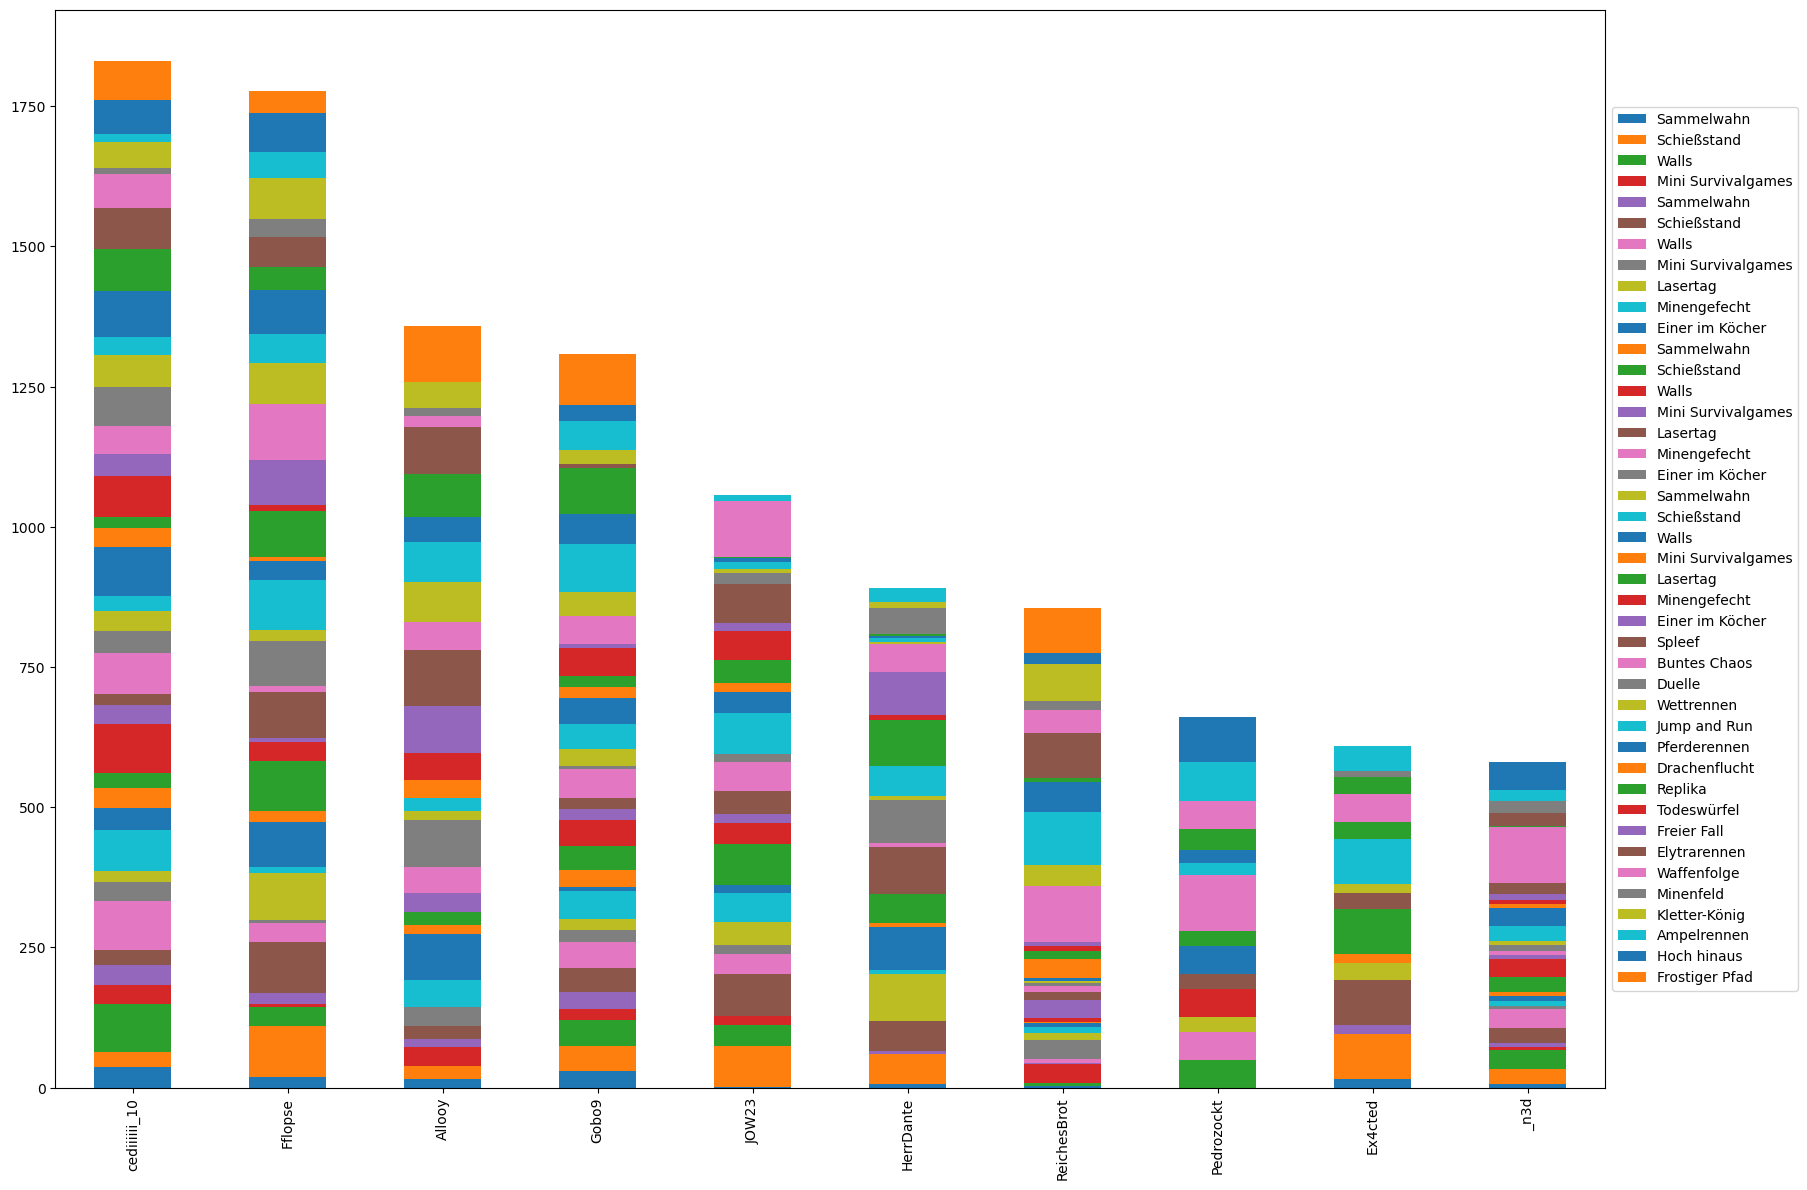

In [27]:
import matplotlib.pyplot as plt
import plotly.express as px

# print(outDf)

# sum all lines to get the total score

outDf['Total'] = outDf.sum(axis=1)

outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# crop df to the top 10 players and plot the data, as a stacked barplot, place legend outside

cropDf = outDf.head(10)

cropDf = cropDf.drop(columns=['Total'])

cropDf.plot(kind='bar', stacked=True, figsize=(20, 14))

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.show()

In [28]:
outDf

,Sammelwahn,Schießstand,Walls,Mini Survivalgames,Sammelwahn,Schießstand,Walls,Mini Survivalgames,Lasertag,Minengefecht,...,Todeswürfel,Freier Fall,Elytrarennen,Waffenfolge,Minenfeld,Kletter-König,Ampelrennen,Hoch hinaus,Frostiger Pfad,Total
cediiiiii_10,36.428571,26.666667,86.666667,33.333333,36.428571,26.666667,86.666667,33.333333,20.000000,72.5,...,0.0,0.0,73.333333,60.0,10.000000,46.666667,15.0,60.0,70.0,1830.735321
Fflopse,19.761905,90.000000,33.333333,6.666667,19.761905,90.000000,33.333333,6.666667,83.333333,10.0,...,0.0,0.0,53.333333,0.0,33.333333,73.333333,45.0,70.0,40.0,1777.756357
Allooy,15.238095,23.333333,0.000000,33.333333,15.238095,23.333333,0.000000,33.333333,0.000000,47.5,...,0.0,0.0,83.333333,20.0,13.333333,46.666667,0.0,0.0,100.0,1358.316459
Gobo9,30.238095,43.333333,46.666667,20.000000,30.238095,43.333333,46.666667,20.000000,20.000000,50.0,...,0.0,0.0,6.666667,0.0,0.000000,26.666667,50.0,30.0,90.0,1307.936200
JOW23,0.952381,73.333333,36.666667,16.666667,0.952381,73.333333,36.666667,16.666667,40.000000,52.5,...,0.0,0.0,0.000000,100.0,0.000000,0.000000,10.0,0.0,0.0,1056.694637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Steavn,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Tammywood,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Radattel,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000
Tomiokey,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000


In [29]:
import plotly.graph_objects as go

# Sum all columns to get the total score
outDf['Total'] = outDf.sum(axis=1)

# Sort by total score and fill N/A values with 0
outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# Crop to top 10 players
cropDf = outDf.head(20).copy()

# Drop the 'Total' column for plotting
cropDf = cropDf.drop(columns=['Total'])

# Create a color palette
color_palette = px.colors.qualitative.Safe

# Create the stacked bar plot
fig = go.Figure()

for column in cropDf.columns.difference(['Player']):
    fig.add_trace(go.Bar(
        x=cropDf.index,
        y=cropDf[column],
        name=column,
        marker_color=color_palette[len(fig.data) % len(color_palette)]
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Overall Record Comparison - Top 20 Players',
    xaxis=dict(title='Player'),
    yaxis=dict(title='Points'),
    #height=800,
    #width=1000,
    legend=dict(
        x=1.05,
        y=0.5,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(0, 0, 0, 0)'
    ),
    margin=dict(r=200),  # Adjust right margin to make room for the legend
    annotations=[
        dict(
            x=0.5,
            y=-0.235,
            xref='paper',
            yref='paper',
            text='Max 100 points per minigame. Records #1 through #10 are considered (#1: 100, #2: 90, ..., #10: 10). If a minigame has multiple maps, the 100 points are distributed equally. fflopse.github.io/MCP-Records/data-analysis/global-ranking.ipynb',
            showarrow=False,
            font=dict(size=12),
            xanchor='center'
        )
    ]
)

fig.show()

# save the plot as an html file

fig.write_html('out/overall_record_comparison.html')

In [30]:
import plotly.graph_objects as go

# Sum all columns to get the total score
outDf['Total'] = outDf.sum(axis=1)

# Sort by total score and fill N/A values with 0
outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# Crop to top 10 players
cropDf = outDf.head(40).copy()

# Drop the 'Total' column for plotting
cropDf = cropDf.drop(columns=['Total'])

# Create a color palette
color_palette = px.colors.qualitative.Safe

# Create the stacked bar plot
fig = go.Figure()

for column in cropDf.columns.difference(['Player']):
    fig.add_trace(go.Bar(
        x=cropDf.index,
        y=cropDf[column],
        name=column,
        marker_color=color_palette[len(fig.data) % len(color_palette)]
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Extended Overall Record Comparison - Top 40 Players',
    xaxis=dict(title='Player'),
    yaxis=dict(title='Points'),
    #height=800,
    #width=1000,
    legend=dict(
        x=1.05,
        y=0.5,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(0, 0, 0, 0)'
    ),
    margin=dict(r=200),  # Adjust right margin to make room for the legend
    annotations=[
        dict(
            x=0.5,
            y=1.1635,
            xref='paper',
            yref='paper',
            text='Max 100 points per minigame. Records #1 through #10 of games & maps in the active pool are considered (#1: 100, #2: 90, ..., #10: 10). If a minigame has multiple maps, the 100 points are distributed equally. fflopse.github.io/MCP-Records/data-analysis/global-ranking.ipynb',
            showarrow=False,
            font=dict(size=12),
            xanchor='center'
        )
    ]
)

fig.show()

# save the plot as an html file

fig.write_html('out/ext_overall_record_comparison.html')

In [31]:
import plotly.graph_objects as go

# Sum all columns to get the total score
outDf['Total'] = outDf.sum(axis=1)

# Sort by total score and fill N/A values with 0
outDf = outDf.sort_values(by='Total', ascending=False).fillna(0)

# Crop to top 10 players
cropDf = outDf.head(100).copy()

# Drop the 'Total' column for plotting
cropDf = cropDf.drop(columns=['Total'])

# Create a color palette
color_palette = px.colors.qualitative.Safe

# Create the stacked bar plot
fig = go.Figure()

for column in cropDf.columns.difference(['Player']):
    fig.add_trace(go.Bar(
        x=cropDf.index,
        y=cropDf[column],
        name=column,
        marker_color=color_palette[len(fig.data) % len(color_palette)]
    ))

# Update layout
fig.update_layout(
    barmode='stack',
    title='Extended Overall Record Comparison - Top 100 Players',
    xaxis=dict(title='Player'),
    yaxis=dict(title='Points'),
    #height=800,
    #width=1000,
    legend=dict(
        x=1.05,
        y=0.5,
        traceorder='normal',
        font=dict(size=12),
        bgcolor='rgba(255, 255, 255, 0)',
        bordercolor='rgba(0, 0, 0, 0)'
    ),
    margin=dict(r=200),  # Adjust right margin to make room for the legend
    annotations=[
        dict(
            x=0.5,
            y=1.1635,
            xref='paper',
            yref='paper',
            text='Max 100 points per minigame. Records #1 through #10 of games & maps in the active pool are considered (#1: 100, #2: 90, ..., #10: 10). If a minigame has multiple maps, the 100 points are distributed equally. fflopse.github.io/MCP-Records/data-analysis/global-ranking.ipynb',
            showarrow=False,
            font=dict(size=12),
            xanchor='center'
        )
    ]
)

fig.show()

# save the plot as an html file

fig.write_html('out/full_overall_record_comparison.html')

In [32]:
outDf['Total'].to_clipboard()